In [1]:
# pip install -r requirements.txt --trusted-host pypi.org --trusted-host files.pythonhosted.org

In [2]:
import re
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score
from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import Whitespace
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
data_train = pd.read_csv('./data/h2i_01_asset_type_train.csv')
data_valid = pd.read_csv('./data/h2i_01_asset_type_valid.csv')
data_test = pd.read_csv('./data/h2i_01_asset_type_test.csv')

In [4]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.pre_tokenizer = Whitespace()

tokenizer.enable_padding(pad_id=0, pad_token='<pad>')

In [5]:
texts = [text.lower() for text in list(data_train['text'])]

In [6]:
with open('texts.txt', 'w') as f:
    for text in texts:
        f.write("%s\n" % text)

In [7]:
tokenizer.train(
    files=['texts.txt'],
    vocab_size=3_000,
    min_frequency=2,
    special_tokens=['<pad>', '<unk>']
    )

In [8]:
tokenizer.save('tokenizer.json')

In [9]:
tokens_list = [tokenizer.encode(text).ids for text in texts]

In [10]:
data_train['tokens'] = tokens_list 

In [11]:
len_list = [len(tokens) for tokens in list(data_train['tokens'])]

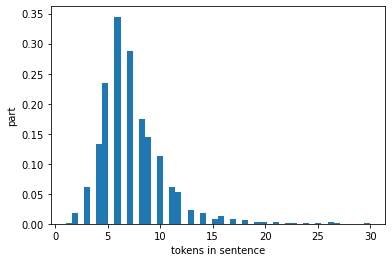

In [12]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(len_list, density=True, bins=50)
plt.ylabel('part')
plt.xlabel('tokens in sentence');

In [13]:
max_len = 16

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

    def __init__(self, tokens, labels, max_len):
        self.tokens = tokens
        self.labels = labels
        self.max_len = max_len


    def __len__(self):
        return len(self.tokens)


    def __getitem__(self, idx):
        label = self.labels[idx]
        label = torch.tensor(label)
        tokens = self.tokens[idx]
        out = torch.zeros(self.max_len, dtype=torch.long)
        out[:len(tokens)] = torch.tensor(tokens, dtype=torch.long)[:self.max_len]
        return out, label

In [36]:
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

y_train = data_train['label'].values

counts = np.bincount(y_train.astype(int))
labels_weights = 1. / counts
weights = labels_weights[y_train.astype(int)]
sampler = WeightedRandomSampler(weights, len(weights))

In [37]:
labels = list(data_train['label'])
train_dataset = CustomDataset(tokens_list, labels, max_len)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=20, shuffle=False)

In [38]:
valid_texts = [text.lower() for text in list(data_valid['text'])]
valid_ids = [tokenizer.encode(text).ids for text in valid_texts]
valid_labels = list(data_valid['label'])
valid_dataset = CustomDataset(valid_ids, valid_labels, max_len)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=False)

In [39]:
test_texts = [text.lower() for text in list(data_test['text'])]
test_ids = [tokenizer.encode(text).ids for text in test_texts]
test_labels = list(data_test['label'])
test_dataset = CustomDataset(test_ids, test_labels, max_len)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# pip install pytorch-metric-learning --trusted-host pypi.org --trusted-host files.pythonhosted.org

In [30]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [31]:
import torch
import torch.nn as nn


class NeuralNetworkML(nn.Module):


    def __init__(self, hidden_dim=128, vocab_size=3000, embedding_dim=300, linear_dim=128, dropout=0.3):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)   
        self.fc_layer = nn.Linear(hidden_dim * 2, linear_dim)


    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        lstm_out, (ht, ct) = self.lstm_layer(embeddings)
        out = ht.transpose(0, 1)
        out = out.reshape(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [29]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [32]:
model = NeuralNetworkML(hidden_dim=256, vocab_size=3000, embedding_dim=300, dropout=0.1)

In [34]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)

In [35]:
model.to(device)

NeuralNetworkML(
  (embedding_layer): Embedding(3000, 300)
  (lstm_layer): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc_layer): Linear(in_features=512, out_features=128, bias=True)
)

In [40]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    sum_loss = 0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        sum_loss += loss
        loss.backward()
        optimizer.step()
    print(sum_loss)

  1%|▏         | 2/136 [00:00<00:09, 14.32it/s]

tensor(13.5579, grad_fn=<AddBackward0>)


  1%|▏         | 2/136 [00:00<00:08, 15.77it/s]

tensor(11.7702, grad_fn=<AddBackward0>)


  1%|▏         | 2/136 [00:00<00:08, 16.71it/s]

tensor(9.4390, grad_fn=<AddBackward0>)


  1%|▏         | 2/136 [00:00<00:08, 15.34it/s]

tensor(7.7116, grad_fn=<AddBackward0>)


  1%|▏         | 2/136 [00:00<00:07, 18.40it/s]

tensor(7.4307, grad_fn=<AddBackward0>)


  1%|▏         | 2/136 [00:00<00:11, 11.31it/s]

tensor(5.9084, grad_fn=<AddBackward0>)


  1%|▏         | 2/136 [00:00<00:07, 17.73it/s]

tensor(4.9923, grad_fn=<AddBackward0>)


  1%|▏         | 2/136 [00:00<00:07, 18.14it/s]

tensor(3.2132, grad_fn=<AddBackward0>)


  1%|▏         | 2/136 [00:00<00:09, 14.20it/s]

tensor(3.6171, grad_fn=<AddBackward0>)


100%|██████████| 136/136 [00:09<00:00, 14.36it/s]

tensor(5.1715, grad_fn=<AddBackward0>)


In [59]:
class ExtNet(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained = pretrained_model
        self.new_layers = nn.Sequential(nn.Linear(128, 64),
                                           nn.ReLU(),
                                           nn.Linear(64, 5))
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.new_layers(x)
        x = torch.squeeze(x, 1)
        x = torch.sigmoid(x)
        return x

In [60]:
def train_nn(model, optimizer, loss_function, train_loader, valid_loader, test_loader, device, epochs=10):
    best_score = 0
    for epoch in range(epochs):
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predict = model(inputs)
            loss = loss_function(predict, labels)
            loss.backward()
            optimizer.step()
        _, _, score_valid = eval_nn(model, valid_loader)
        _, _, score_test = eval_nn(model, test_loader)
        print(epoch, score_valid, score_test)
        if score_valid > best_score:
            best_score = score_valid
    return best_score

In [61]:
def eval_nn(model, data_loader):
    predicted = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            x = x.to(device)
            outputs = model(x)
            _, predict = torch.max(outputs.data, 1)
            predict = predict.cpu().detach().numpy().tolist()
            predicted += predict
            labels += y
        score = f1_score(labels, predicted, average='macro')
    return labels, predicted, score

In [62]:
ext_model = ExtNet(model)
ext_model.to(device)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(ext_model.parameters())
score = train_nn(ext_model, optimizer, loss_function, train_loader, valid_loader, test_loader, device)
print(score)

  0%|          | 0/136 [00:00<?, ?it/s]

0 0.94919676174815 0.9195454545454546


  1%|          | 1/136 [00:00<00:17,  7.54it/s]

1 0.9519952541032233 0.9224760931454852


  1%|          | 1/136 [00:00<00:16,  8.15it/s]

2 0.94919676174815 0.9224760931454852


  1%|          | 1/136 [00:00<00:15,  8.61it/s]

3 0.94919676174815 0.9224760931454852


  1%|          | 1/136 [00:00<00:14,  9.57it/s]

4 0.94919676174815 0.9224760931454852


  1%|          | 1/136 [00:00<00:20,  6.43it/s]

5 0.9547958214624882 0.9224760931454852


  0%|          | 0/136 [00:00<?, ?it/s]

6 0.94919676174815 0.9252922077922078


  1%|          | 1/136 [00:00<00:26,  5.03it/s]

7 0.94919676174815 0.9252922077922078


  1%|          | 1/136 [00:00<00:21,  6.37it/s]

8 0.94919676174815 0.9252922077922078


100%|██████████| 136/136 [00:20<00:00,  6.53it/s]


9 0.94919676174815 0.9252922077922078
0.9547958214624882
